# ATP Tennis Match Data Analysis
## by Erin Matheson
December 2017,
 ACME Volume 3


# Introduction

Tennis is so much more than who gets the most points. Matches have been played where the loser won more points than the winner overall. Tennis progresses from points to a game, games to a set, and sets to a match.
A player must win four points to win a game (winning by at least two) and six games to win a set. A set must also be won by two games, but different rules apply if the game score reaches 6-6. Matches are usually best 2 out of 3 sets. Points 0 through 3 in each game are called Love, 15, 30, and 40, respectively. If a game is tied at 40-40 the score is called 'duece.' In tennis, each new game starts at Love-Love, or "Love-all." 
Because of this, tennis players cannot rack up points and 'get ahead,' so to speak, like in basketball. Adding up number of games won by each player in a match will not always reflect who won.

Instead of exploring actual game scores for each set, this project will deal with wins and losses of matches.

# Data Collection


The tennis data used in this project is taken from Kaggle (https://www.kaggle.com/gmadevs/atp-matches-dataset/data), downloaded as multiple csv files. Sports statistics are usually dependable unless reported inaccurately. Not all possible tennis statistics were recorded for each match and not all matches have every column filled with information. Numbers in this data seems reliable since it is from Association of Tennis Professionals' (ATP) matches.


The data came in 18 separate csv files, one for each year. Each entry in these datasets corresponds to an ATP singles' match. This dataset is in no way comprehensive. All players in a tournament are accounted for because the first round matches are recorded, but it is important to note that not every match in each tournament is included in this dataset. There may exist some bias on which matches were chosen to be included.


Columns in this data set include information about the winner, loser, type of court played on, and the score. The winner and loser each have columns for their height, age, ranking, and game statistics. Those statistics include number of aces, double faults, break points faced and saved, first serves in, and points won on first serve as well as second serve. See the Appendix for a full list of the columns and their meanings.


## Research Questions

It is commonly known among tennis players that the serve is the most important shot because it starts each point. Players trade off who serves at each new game, and the server gets two tries to start each point.
If neither serve goes in, the opponent wins the point by default. First serves are usually hit harder and with less spin than second serves, so the more first serves you get in, theoretically, the better chance you have of winning your service games. A goal of this project is to see how correlated first serve percentage is to winning matches.

Lefties also tend to have an advantage because the spin they put on the ball is opposite of what players are used to since most people are right-handed. I want to see if this dataset shows a noticable difference in winning percentages between right and left handed players.


Questions to be answered by investigating this dataset are:

   1. How does first serve percentage affect winning percentage?
    
   2. Do left-handed players tend to beat their right-handed opponents?
    

# Data Cleaning

In [12]:
import numpy as np
import pandas as pd
import re
from matplotlib import cm, pyplot as plt
%matplotlib inline

In [13]:
plt.rcParams["figure.dpi"] = 200     # Raise figure quality
pd.set_option("display.max_columns", 55)

As can be seen in the auxilary python file called "tennis_cleaning.py," I read each csv file into a data frame and then stacked the data frames on top of each other to create one big table of tennis matches.

The most essential part of this data, for purposes of this project, is who won and who lost each match. If an entry was missing the name of the winner or loser, I dropped that row. I also dropped columns that carried no significant meaning for this project, namely ID numbers.


In [14]:
from tennis_cleaning import clean_TennisData

Tennis = clean_TennisData()

In [35]:
Tennis.shape


The combined and cleaned data frame has 43 columns for each of the 53,571 entries.

Here are the 43 columns:

In [5]:
print(Tennis.columns)

Index(['tourney_name', 'surface', 'draw_size', 'tourney_level', 'winner_seed',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_country',
       'winner_age', 'winner_rank', 'winner_rank_points', 'loser_seed',
       'loser_name', 'loser_hand', 'loser_ht', 'loser_country', 'loser_age',
       'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'year'],
      dtype='object')


What we truly want from this dataset of matches is information about each player, like how many times they won or lost a match, their overall serving percentages, and what country they are from. This way we can visualize what the overall set of tennis players looks like. The next step is to create a data frame where each row is statistics for a tennis player.


## Feature Engineering

In [16]:
# Group data by winners and losers
W_players = Tennis.groupby("winner_name").count()["tourney_name"]
L_players = Tennis.groupby("loser_name").count()["tourney_name"]
# no NaNs in tourney_name column, so counting 
# how many of those there are is the correct number we want

W_players.name = "wins"
L_players.name = "losses" 

In [17]:
# Outer join Winner and Loser groupings to combine overlaps
Players = pd.DataFrame(W_players).join(pd.DataFrame(L_players),
                                       how="outer")
Players.fillna(value=0, inplace=True)

# add column that is number of matches played
Players["num_matches"] = Players['wins'] + Players['losses']
# add column that is winning percentage
Players["win_pct"] = Players['wins'] / Players["num_matches"]


After creating these groupings, corresponding winner and loser groups will be combined and put into one data frame. This gets rid of repeats. A unique player's name is the index of each row, ordered alphabetically.

In [18]:
Players.head(5)

,wins,losses,num_matches,win_pct
Abd Hazli Bin Zainuddin,1.0,3.0,4.0,0.250000
Abdelhak Hameurlaine,1.0,5.0,6.0,0.166667
Abdul Mumin Babalola,0.0,3.0,3.0,0.000000
Abdulhameed Alshatti,0.0,2.0,2.0,0.000000
Abdulhamid Mubarak,0.0,1.0,1.0,0.000000


For each player, columns will be added for what country they are from as well as their overall 1st and 2nd serve percentages.

In [19]:
# Calculate 1st serve percentage for each player

# Create empty dictionary
serve1_pct = {}

for player in Players.index:
    # matches where player was the winner
    W_matches = Tennis[Tennis["winner_name"] == player]
    Serve1_total = W_matches["w_svpt"].sum()
    Serve1_made = W_matches["w_1stIn"].sum()
    # matches where player was the loser
    L_matches = Tennis[Tennis["loser_name"] == player]
    Serve1_total += L_matches["l_svpt"].sum()
    Serve1_made += L_matches["l_1stIn"].sum()
    
    serve1_pct[player] = float(Serve1_made) / float(Serve1_total)

# Add column to Player data frame
Players["1st_serve_%"] = serve1_pct.values()
    

In [20]:
# Calculate 2nd serve percentage for each player

# Create empty dictionary
serve2_pct = {}

for player in Players.index:
    
    # matches where player was the winner
    W_matches = Tennis[Tennis["winner_name"] == player]
    Serve2_total = W_matches["w_svpt"].sum() \
                    -W_matches["w_1stIn"].sum()
    Serve2_missed = W_matches["w_df"].sum()    
    
    # matches where player was the loser
    L_matches = Tennis[Tennis["loser_name"] == player]
    Serve2_total += (L_matches["l_svpt"].sum() \
                    -L_matches["l_1stIn"].sum())
    Serve2_missed += L_matches["l_df"].sum()
    
    serve2_pct[player]=float(Serve2_total-Serve2_missed)/float(Serve2_total)

    
# Add column to Player data frame
Players["2nd_serve_%"] = serve2_pct.values()
    

If a player has more than one country attatched to their name, "unknown" will put in their country column.

In [24]:
# Adding country 

# Create empty dictionary
countries = {}
#win_groups = Tennis.groupby("winner_name")
#lose_groups = Tennis.groupby("loser_name")

for player in Players.index:
    
    matches = Tennis[Tennis["winner_name"] == player]
    #matches = win_groups.get_group(player)
    
    if len(matches) == 0:
        #matches = lose_groups.get_group(player)
        matches = Tennis[Tennis["loser_name"] == player]
        
        if len(set(matches["loser_country"])) == 1:
            countries[player] = list(matches["loser_country"])[0]
        else:
            countries[player] = "unknown"       
    else:
         
        if len(set(matches["winner_country"])) == 1: 
            countries[player] = list(matches["winner_country"])[0]
        else:
            countries[player] = "unknown"
       
    
Players["country"] = countries.values()


In [25]:
Players.sample(5)

,wins,losses,num_matches,win_pct,1st_serve_%,2nd_serve_%,country
Jad Ayoub,1.0,0.0,1.0,1.000000,NaN,NaN,LIB
Walter Trusendi,0.0,1.0,1.0,0.000000,NaN,NaN,ITA
Alex Corretja,155.0,105.0,260.0,0.596154,0.533852,0.919373,ESP
Ariez Elyaas Deen Heshaam,0.0,4.0,4.0,0.000000,NaN,NaN,MAS
Scott Humphries,0.0,4.0,4.0,0.000000,NaN,NaN,USA


In [37]:
Players.shape

(2107, 7)

This dataset includes 2,107 unique tennis players.

It is important to note that not every player has a number in each column. Due to incomplete or missing data, many values are NaN. This data gets automatically left out when graphing the data frame.

# Data Visualization

Text(0.5,1,'Number of Matches Played versus Winning percentage')

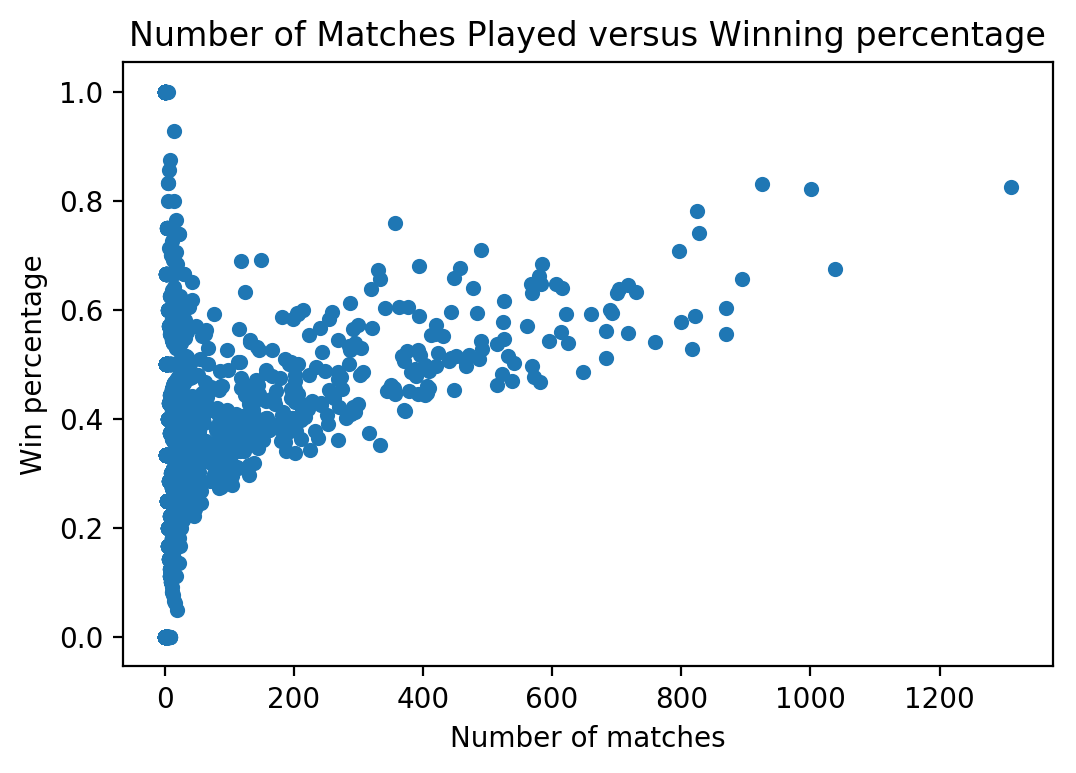

In [27]:
Players.plot(kind="scatter", x="num_matches", y="win_pct")
plt.ylabel("Win percentage")
plt.xlabel("Number of matches")
plt.title("Number of Matches Played versus Winning percentage")

Many players in the dataset have only one match or very few compared to the 1000 or more that a few players have. This is why you see so many dots near zero with a wide range of winning percentages.

Text(0.5,1,'Frequencies of Winning Percentages')

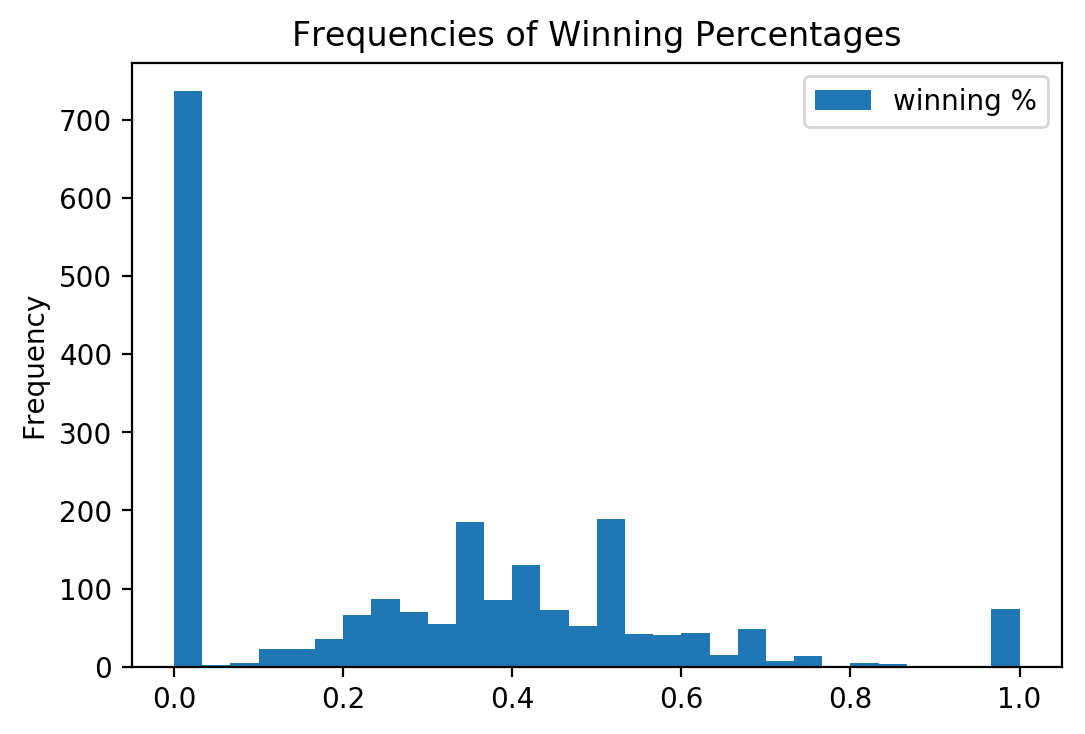

In [28]:
Players.plot(kind="hist", y="win_pct", label="winning %", bins=30)
plt.title("Frequencies of Winning Percentages")

Over 700 players have an extremely low winning percentage. This could be because some players only have a few matches in the dataset.

Text(0.5,1,'Winning percentages of players who have played the most matches (top 10)')

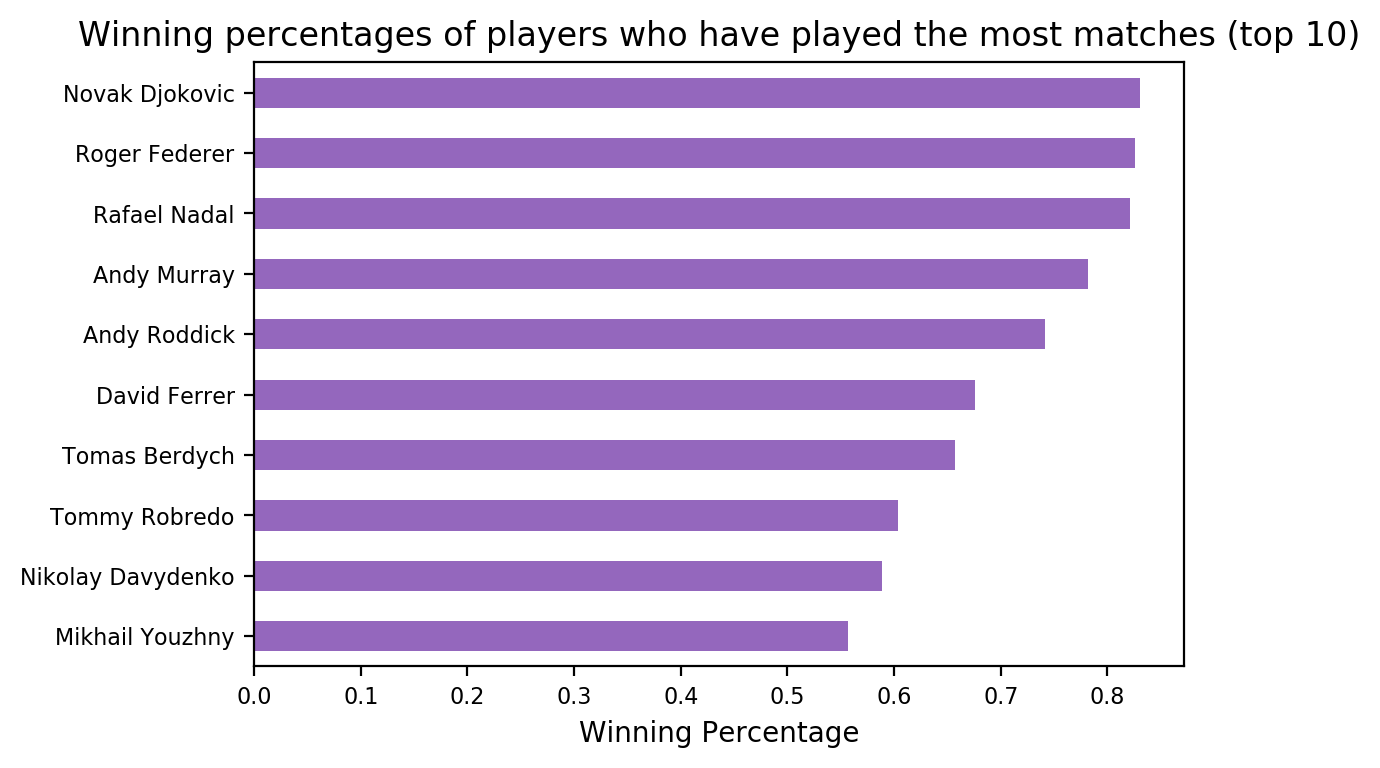

In [29]:
# Find players in data set who have the most matches played
MostMatches = Players.sort_values("num_matches").iloc[-50:]

MostMatches[-10:].sort_values("win_pct")["win_pct"].plot(kind="barh",
                                            color='C4',fontsize=8)

plt.xlabel("Winning Percentage", fontsize=10)
plt.title("Winning percentages of players who have played the most matches (top 10)")


Out of those who play the most, the top 4 players with the best winning percentages are Novak Djokovic, Roger Rederer, Rafael Nadal, and Andy Murray. These 4 tennis players have been top 4 in the world (in different orders) for the past decade.

From now on, sorting will happen on this already sorted group of players who have the most matches played in this dataset. 
If winning percentage was sorted for every single player, those who only have one match documented either has winning percentage of 0 or 1. We want enough data points to get a meaningful statistic.

Text(0.5,0,'Percentage')

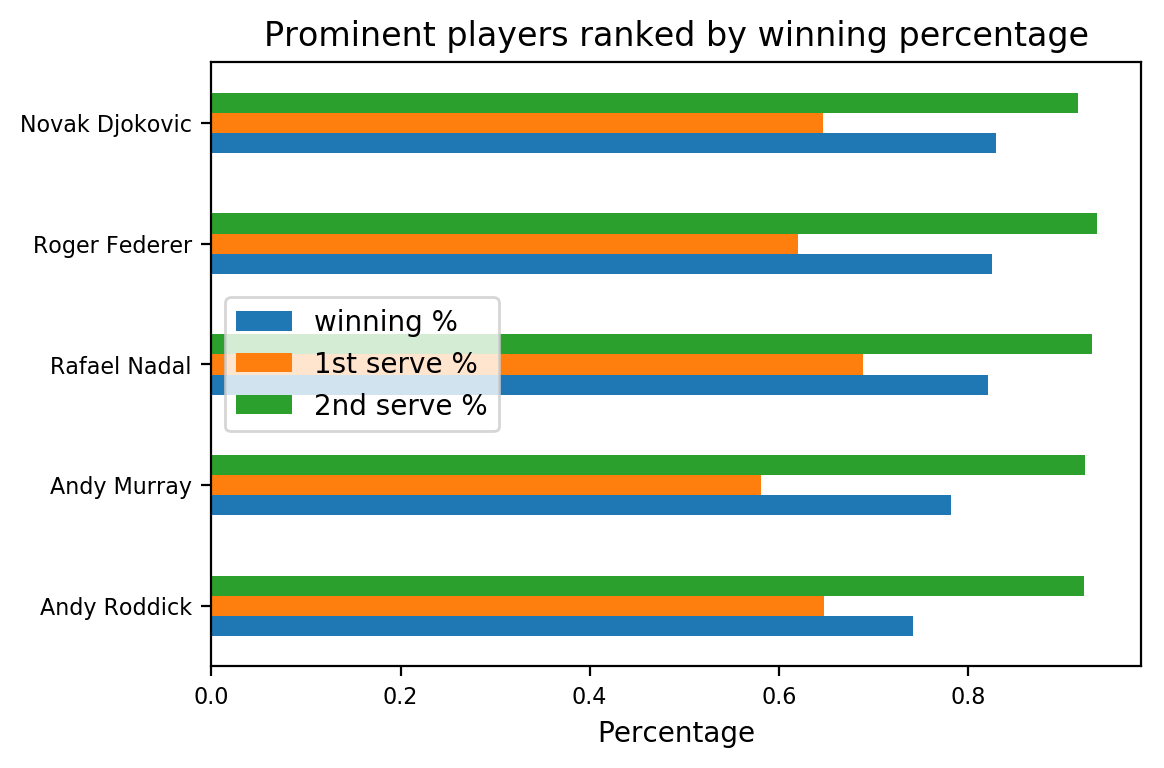

In [30]:
MostMatches.sort_values("win_pct").iloc[-5:].loc[:,
                            ["win_pct","1st_serve_%",
                            "2nd_serve_%"]].plot(kind='barh'
                                                 ,fontsize=8)
plt.legend(["winning %", "1st serve %", "2nd serve %"],
                   loc="center left", fontsize='medium')
plt.title("Prominent players ranked by winning percentage")
plt.xlabel("Percentage")

It makes sense that the second serve percentages are higher than the first serve percentages. First serves are usually hit harder since players know they have a second chance.

Text(0.5,0,'Percentage')

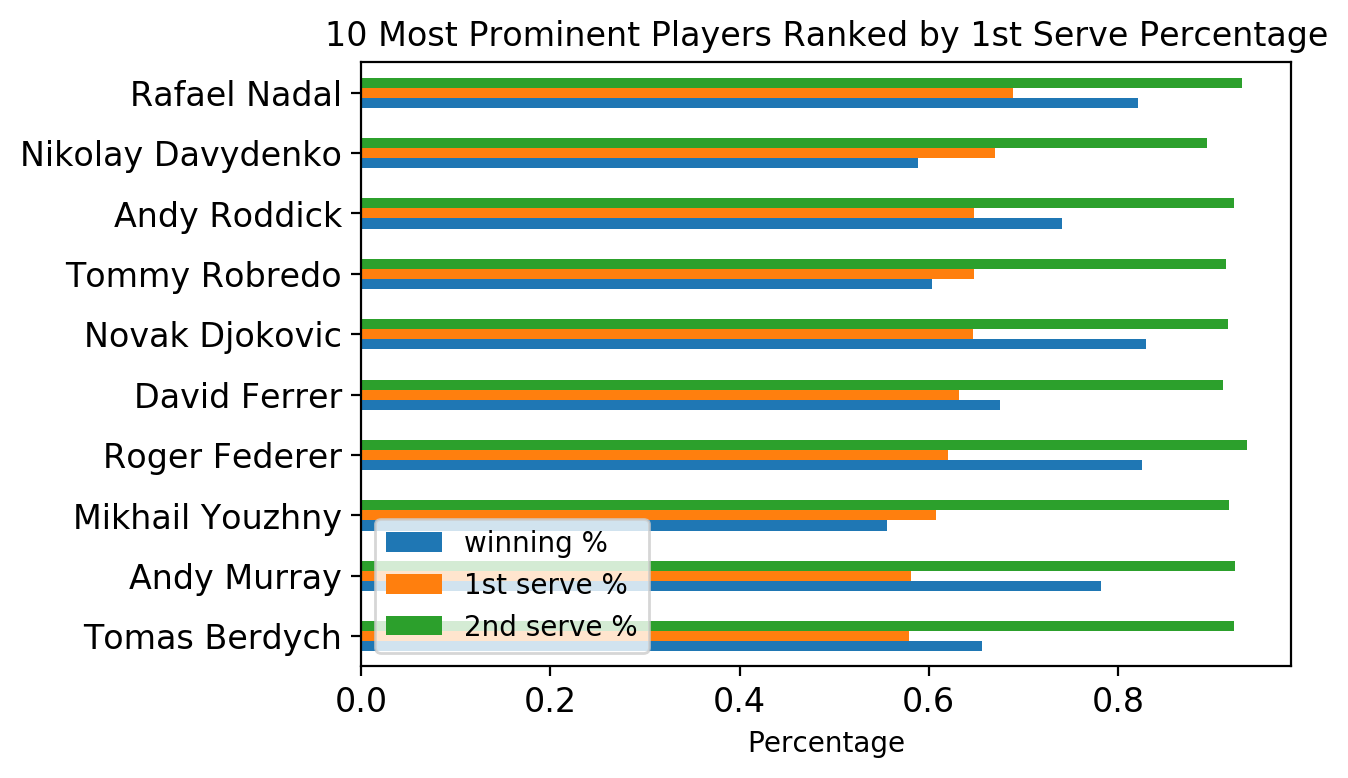

In [41]:
MostMatches.sort_values("1st_serve_%").iloc[-10:].loc[:,
                        ["win_pct","1st_serve_%",
                         "2nd_serve_%"]].plot(kind='barh',
                                              fontsize=12)
plt.legend(["winning %", "1st serve %", "2nd serve %"],
           loc="lower left", fontsize='medium')
plt.title("10 Most Prominent Players Ranked by 1st Serve Percentage")
plt.xlabel("Percentage")

When sorted by 1st serve percentage, the winning percentages do not obviously correlate.

Text(0.5,1,'Winning percentage vs. 1st serve percentage')

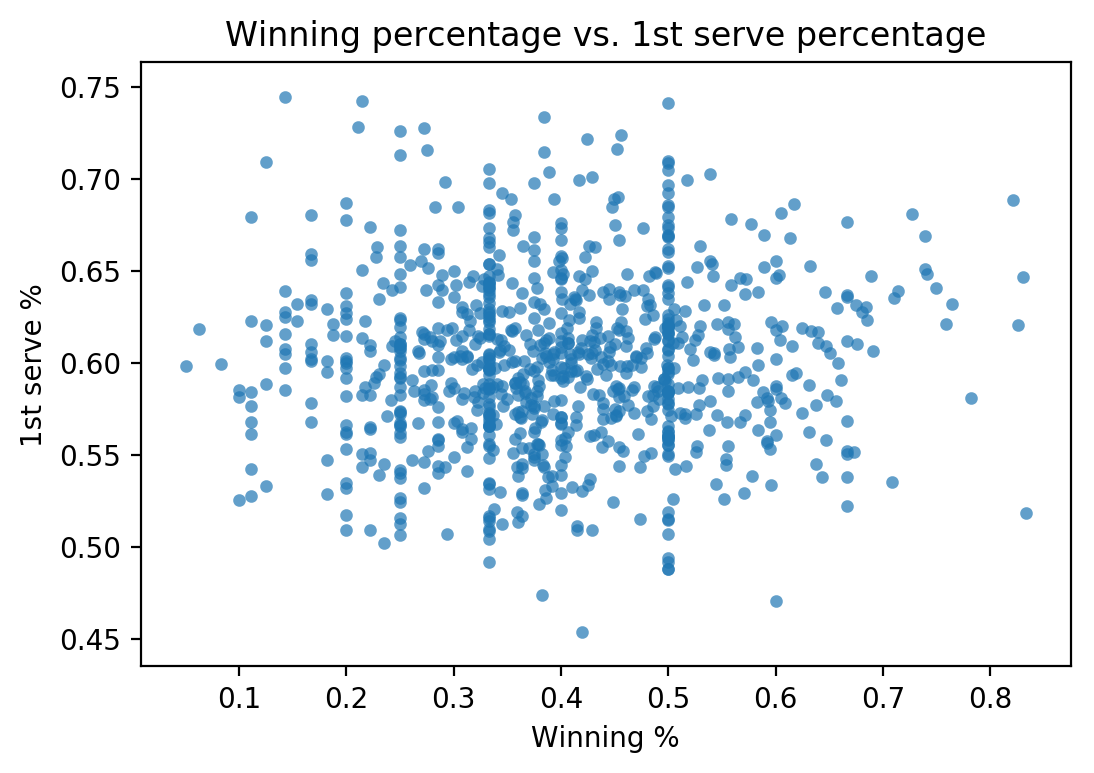

In [31]:
Players.plot(kind="scatter", x="win_pct", y="1st_serve_%",
                         alpha=0.7, linewidths=0.05)
plt.xlabel('Winning %')
plt.ylabel("1st serve %")
plt.title("Winning percentage vs. 1st serve percentage")

This plot shows no correlation between the two percentages.


Text(0,0.5,'1st serve %')

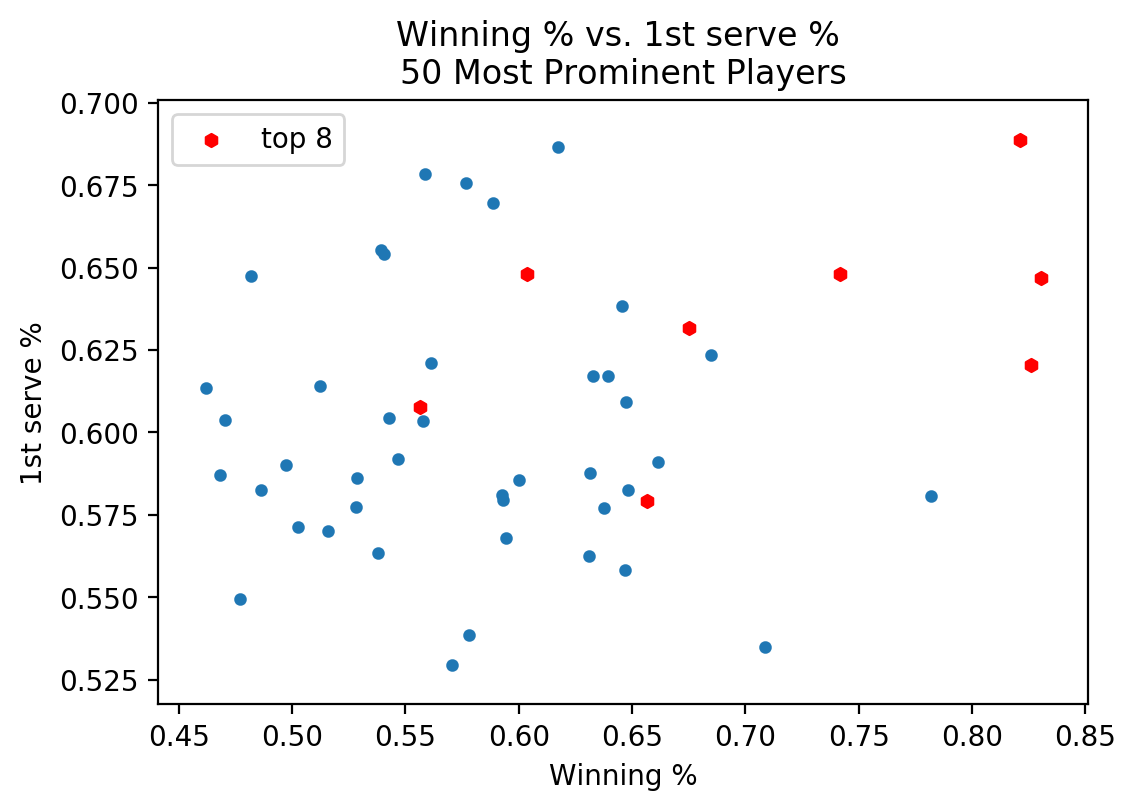

In [32]:
plt.figure
ax = plt.subplot(111)
MostMatches.plot(kind="scatter", x="win_pct", y="1st_serve_%",
                                     linewidths=0.05, ax=ax)
MostMatches[-8:].plot(kind="scatter", x="win_pct", 
                      y="1st_serve_%", c='r', marker='h',
                      label="top 8", linewidths=1, ax=ax)
plt.title("Winning % vs. 1st serve % \n50 Most Prominent Players")
plt.xlabel('Winning %')
plt.ylabel("1st serve %")

Even looking at players with lots of match data, no trend is showing. Three different players in the top eight have similar 1st serve percentages (around 0.65), but very different winning percentages.

Text(0,0.5,'2nd serve %')

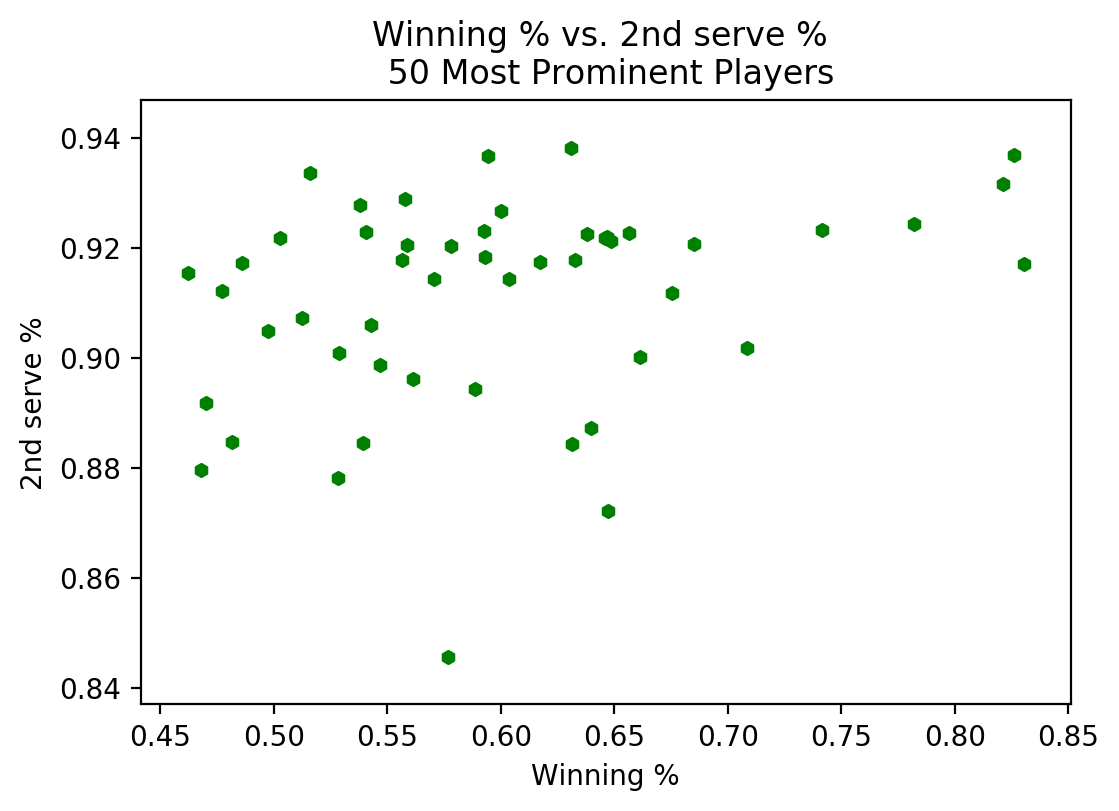

In [33]:
MostMatches.plot(kind="scatter", x="win_pct", 
                      y="2nd_serve_%", c='g', marker='h',
                      linewidths=1)
plt.title("Winning % vs. 2nd serve % \n 50 Most Prominent Players")
plt.xlabel('Winning %')
plt.ylabel("2nd serve %")

In [34]:
# Find matches where it was a Righty vs. a Lefty
def diff_handedness(row):
    # winner's dominant hand is in entry 7
    # loser's dominant hand is in entry 15
    # returns boolean
    return row[6] != row[14]

Tennis["diff_hands"] = [diff_handedness(row) for row in Tennis.values]

DiffHand = Tennis.groupby("diff_hands").get_group(True)

DiffHand.groupby("winner_hand")["winner_hand"].count()

winner_hand
L    5483
R    7134
U     384
Name: winner_hand, dtype: int64

In matches between a left and right handed players, the right handed opponents won more often. Though the meaning of U is not defined anywhere, it most likely stands for "Unknown." This small percentage of players will have to be left out of the comparison.


# Conclusion

From the tournament data used, which is not complete by any means but is still big enough to be valuable, it has been shown that no obvious correlation can we seen between first serve percentage and winning percentage. Athletes should not underestimate the importance of the serve, but it is not a clear indicator of whether you will win or not. In addition, handedness does not play a significant role in winning. Players win and lose matches regardless of their dominant hand.

# Appendix

Names and description of columns in csv files:



tourney_name - Name of the Tournament - String

surface - Surface of the Court (Hard, Clay, Grass) - String

draw_size - Number of people in the tournament - Numeric

tourney_level - Level of tournament - String

winner_seed - Seed of winner - Numeric

winner_name - Name of winner - String

winner_hand - Dominant hand of winner - String

winner_ht - height in cm - Numeric

winner_country - Country of winner - String

winner_age - Age of winner - Numeric

winner_rank -       Numeric

winner_rank_points -    Numeric

loser_seed - Seed of loser - Numeric

loser_name - Name of loser - String

loser_hand - Dominant hand of loser - String

loser_ht - loser's height in cm - Numeric

loser_ioc - Country of loser - String

loser_age - Age of loser - Numeric

loser_rank -        Numeric

loser_rank_points -      Numeric

score - Final score - DateTime

best_of - Best of X number of sets - Numeric

round - Round (Round of 32, 16, Quaterfinal, etc.) - String

minutes - Match length in minutes - Numeric

w_ace - Number of aces for winner - Numeric

w_df - Number of double faults for winner - Numeric

w_svpt - Number of service points played by winner - Numeric

w_1stIn - Number of first serves in for winner - Numeric

w_1stWon - Number of first serve points won for winner - Numeric

w_2ndWon - Number of second serve points won for winner - Numeric

w_SvGms - Number of service games played by winner - Numeric

w_bpSaved - Number of break points saved by winner - Numeric

w_bpFaced - Number of break points faced by winner - Numeric

l_ace - Number of aces for loser - Numeric

l_df - Number of double faults for loser - Numeric

l_svpt - Number of service points played by loser - Numeric

l_1stIn - Number of first serves in for loser - Numeric

l_1stWon - Number of first serve points won for loser - Numeric

l_2ndWon - Number of second serve points won for loser - Numeric

l_SvGms - Number of service games played by loser - Numeric

l_bpSaved - Number of break points saved by loser - Numeric

l_bpFaced - Number of break points faced by loser - Numeric


Some column names were not clealy explained, like if rank meant a player's ATP ranking or their ranking in the tournament. 